<a href="https://colab.research.google.com/github/SisekoC/OpenCV/blob/main/lstm_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from numpy import sqrt,mean,log,diff
from scipy import stats
import matplotlib.pyplot as plt
from datetime import datetime
import yfinance as yf # https://github.com/ranaroussi/yfinance
import pickle
import torch # seems to be necessary to enable keras GPU usage
import tensorflow as tf
from tensorflow import keras

This notebook uses a Long Short-Term Memory (LSTM) network to predict stock prices along the lines of Moghar et al., Procedia Computer Science 170, 1168 (2020). It uses historic stock price data from Yahoo Finance.

In [2]:
tickers_list = ['AAPL', 'WMT', 'IBM', 'TSLA']

# Fetch the data
import yfinance as yf
data = yf.download(tickers_list,'2017-1-1')['Adj Close']
idx = data.index

# Print first 5 rows of the data
print(data.tail())

[*********************100%***********************]  4 of 4 completed

Ticker                           AAPL         IBM        TSLA        WMT
Date                                                                    
2024-09-03 00:00:00+00:00  222.770004  201.279999  210.600006  77.169998
2024-09-04 00:00:00+00:00  220.850006  204.110001  219.410004  77.239998
2024-09-05 00:00:00+00:00  222.380005  202.589996  230.169998  76.959999
2024-09-06 00:00:00+00:00  220.820007  200.740005  210.729996  76.639999
2024-09-09 00:00:00+00:00  220.910004  203.529999  216.270004  77.339996


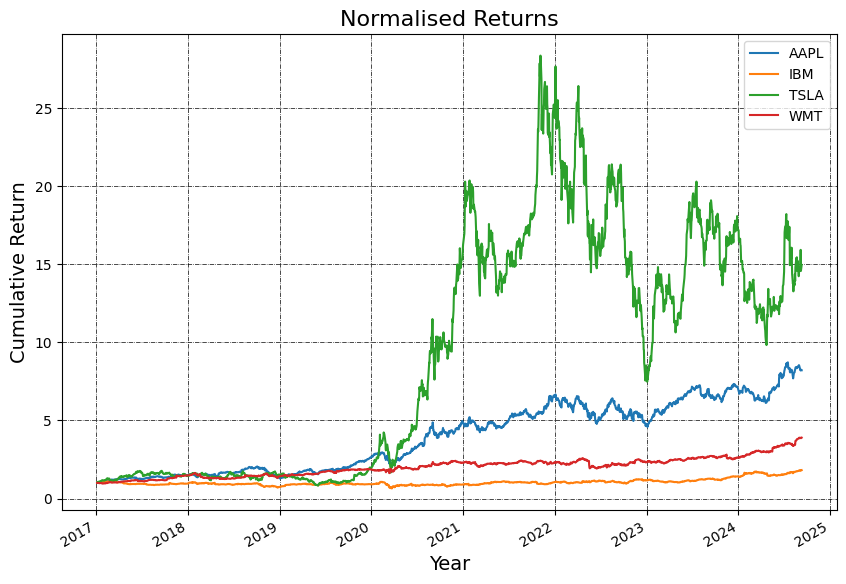

In [3]:
# Plot all the close prices
((data.pct_change()+1).cumprod()).plot(figsize=(10, 7))

# Show the legend
plt.legend()

# Define the label for the title of the figure
plt.title("Normalised Returns", fontsize=16)

# Define the labels for x-axis and y-axis
plt.ylabel('Cumulative Return', fontsize=14)
plt.xlabel('Year', fontsize=14)

# Plot the grid lines
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.show()

In [4]:
def getTimelagDataset(data, lag=60, forecast=5): # takes a numpy array, returns time lagged training data
    X, y, X_last = [], [], []
    for i in range(lag, data.shape[0]-forecast):
        X.append(data[i-lag:i, 0])
        y.append(data[i:i+forecast, 0])

    X, y = np.array(X), np.array(y)
    X    = np.reshape(X, (X.shape[0], X.shape[1], 1)) # one feature (price)

    return X, y

In [5]:
stockname = "TSLA"
lag = 60
n_forecast = 5

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data[[stockname]])
X, y = getTimelagDataset(data, lag, n_forecast)

In [6]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

def LSTMmodel(n_forecast): # model from Moghar et al.
    model = Sequential()
    model.add(LSTM(units=150, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=150, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=150, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100))
    model.add(Dropout(0.2))
    model.add(Dense(units=n_forecast))

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [7]:
model = LSTMmodel(n_forecast)
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True, verbose=1)

with tf.device('/device:GPU:0'):
    model.fit(X, y, epochs=50, batch_size=32, validation_split=0.2, verbose=1, callbacks=[earlyStopping])

Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 0.0398 - val_loss: 0.0043
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0051 - val_loss: 0.0053
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0058 - val_loss: 0.0036
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0040 - val_loss: 0.0045
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0043 - val_loss: 0.0027
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0045 - val_loss: 0.0034
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0039 - val_loss: 0.0045
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0034 - val_loss: 0.0025
Epoch 9/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0029 - val_loss: 0.0035
Epoch 10/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0032 - val_loss: 0.0026
Epoch 11/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0032 - val_loss: 0.0024
Epoch 12/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.

In [8]:
X_test = X[int(-0.2*X.shape[0]):]
y_pred = model.predict(X_test)
y_pred, y = scaler.inverse_transform(y_pred), scaler.inverse_transform(y)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


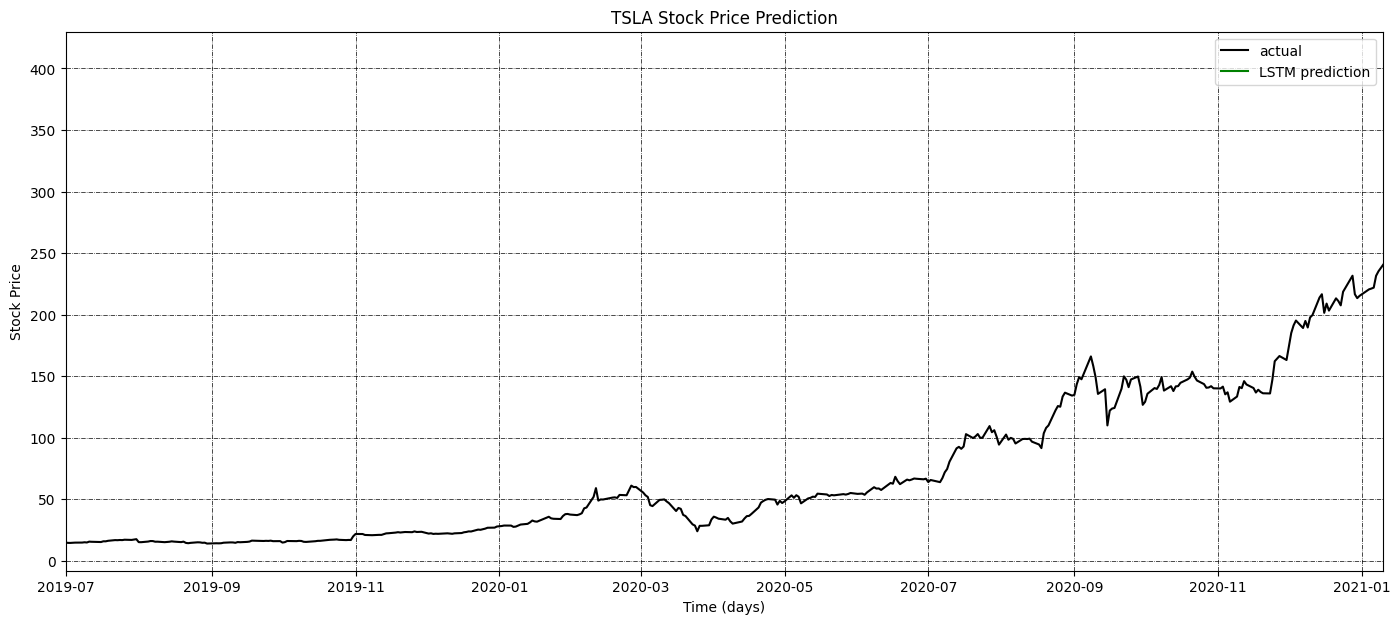

In [13]:
plt.plot(idx[-len(y[:,0]):], y[:,0], color='black', label='actual')
plt.plot(idx[-len(y_pred[:,0]):], y_pred[:,0], color='green', label='LSTM prediction')

# continue idx by lag - assume date format
from datetime import datetime, timedelta, date
startdate = idx[-1]
idx_forecast = idx.copy(deep=True)
for i in range(n_forecast):
    idx_forecast = idx_forecast.append(pd.Index([startdate+timedelta(days=i+1)]))

plt.plot(idx_forecast[-len(y_pred[-1]):], y_pred[-1], color='green')
plt.title(stockname+' Stock Price Prediction')
plt.xlabel('Time (days)')
plt.ylabel('Stock Price')
plt.xlim(date(2019, 7, 1), date(2021, 1, 10))
plt.axvline(x=startdate)
plt.legend()
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)

plt.gcf().set_size_inches(17, 7)
plt.show()
plt.close()